In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.signal as signal
import tqdm

In [2]:
image_original = cv.imread('img1.pgm', cv.IMREAD_GRAYSCALE)
image_rotate = cv.imread('img2.pgm', cv.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(849.5), np.float64(679.5), np.float64(-0.5))

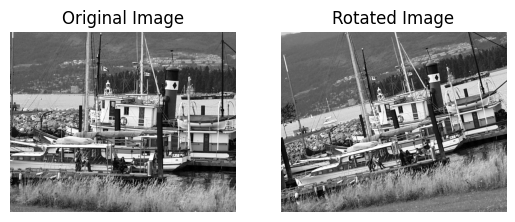

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rotate, cmap='gray')
plt.title('Rotated Image')
plt.axis('off')


In [4]:
def gaussian_filter(img, filter_size=5):
    result = cv.GaussianBlur(img, (filter_size,filter_size), filter_size / 3)
    return result
    
    

In [5]:
def harris_corner(img: np.array, k = 0.06):
    sobel_x = [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]
    sobel_y = [
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ]
    Ix = signal.convolve2d(img,sobel_x, mode='same')
    Iy = signal.convolve2d(img, sobel_y, mode='same')
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    Ixx = gaussian_filter(Ixx.astype(np.float32))
    Iyy = gaussian_filter(Iyy.astype(np.float32))
    Ixy = gaussian_filter(Ixy.astype(np.float32))
    detM = Ixx * Iyy - (Ixy ** 2)
    traceM = Ixx + Iyy
    R = detM - (k * (traceM ** 2))
    quality = 0.01
    threshold = quality * np.max(R)
    R = np.where(R > threshold, R, 0)

    return R



In [6]:
original_corner = harris_corner(gaussian_filter(image_original,filter_size=5))
rotate_corner = harris_corner(gaussian_filter(image_rotate,filter_size=5))



(np.float64(-0.5), np.float64(849.5), np.float64(679.5), np.float64(-0.5))

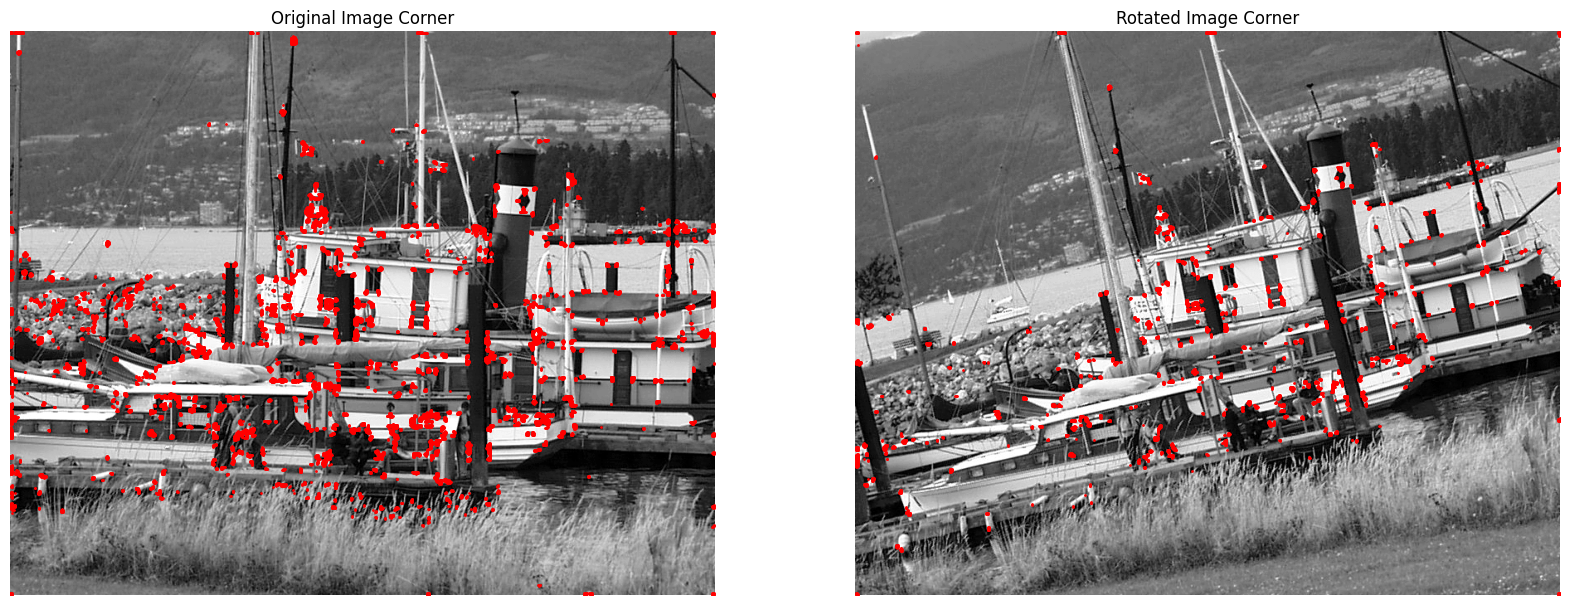

In [7]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(image_original, cmap='gray')
plt.scatter(np.where(original_corner > 0)[1], np.where(original_corner > 0)[0], c='r', s=1)
plt.title('Original Image Corner')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rotate, cmap='gray')
plt.scatter(np.where(rotate_corner > 0)[1], np.where(rotate_corner > 0)[0], c='r', s=1)
plt.title('Rotated Image Corner')
plt.axis('off')



In [53]:
def sift_interesting_point(image , cornors, initial_sigma=1.6):
    plt.figure(figsize=(40, 40))
    octave = 3
    scale_levels = 3
    k = 2**0.5
    keypoints = []
    for o in tqdm.trange(octave):
        img = cv.resize(image, (int(image.shape[1]/(2**o)), int(image.shape[0]/(2**o))))
        dog = []
        scales = []
        scale_index = []
        for i in range(scale_levels):
            sigma = initial_sigma * (2 **(i/scale_levels))
            scale_index.append(sigma)
            gaussian = cv.GaussianBlur(img, (5, 5), sigma)
            dog.append(gaussian)
        for i in range(scale_levels-1):
            dog.append(dog[i+1] - dog[i])
            scales.append(scale_index[i+1]-scale_index[i])
        for x in range(1, dog[0].shape[0]-2):
            for y in range(1, dog[0].shape[1]-2):
                max_scale = -1
                max_value = -1
                for k in range(scale_levels-2):
                    D = dog[k][x-1:x+2, y-1:y+2]
                    if D[1,1] == np.max(D) or D[1,1] == np.min(D):
                        if abs(D[1,1]) > abs(max_value):
                            max_value = D[1,1]
                            max_scale = scale_index[k+1]
                if max_scale != -1 and max_value > 0.5:
                    x_fixed = x * (2**o)
                    y_fixed = y * (2**o)
                    scale_fixed = max_scale * (2**o)
                    keypoints.append((x_fixed, y_fixed, scale_fixed))
    return  keypoints
    

In [55]:
original_keypoints = sift_interesting_point(image_original, original_corner)
# rotate_keypoints = sift_extrema(image_rotate)



100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


<Figure size 4000x4000 with 0 Axes>

(np.float64(-0.5), np.float64(849.5), np.float64(679.5), np.float64(-0.5))

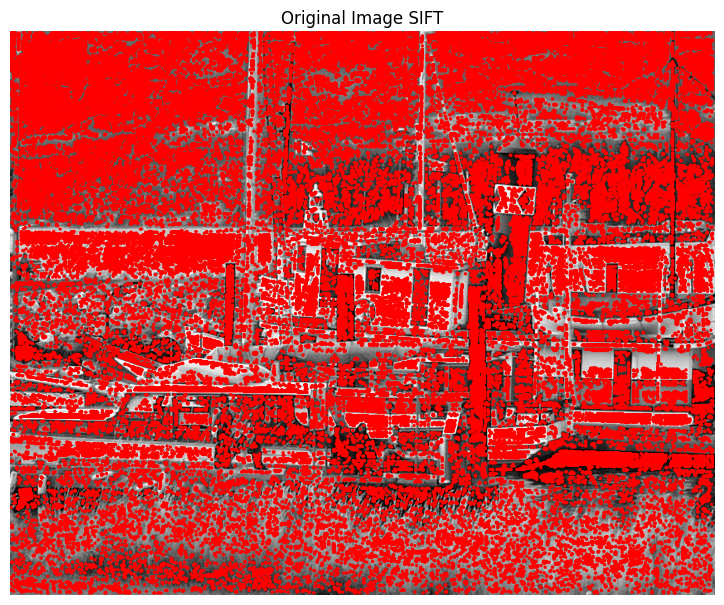

In [56]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(image_original, cmap='gray')
plt.scatter([point[1] for point in original_keypoints], [point[0] for point in original_keypoints], c='r', s=[point[2] for point in original_keypoints])
plt.title('Original Image SIFT')
plt.axis('off')
